Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

def wrangle(X):

    X = X.copy()

    cols_with_zeros = ['longitude', 'latitude', 
                       'gps_height', 'num_private', 
                       'population', 'construction_year']

    duplicates = ['extraction_type_group', 'extraction_type_class', 
                  'payment_type', 'quantity_group', 'source_type',
                  'waterpoint_type_group']

    unusable_variance = ['recorded_by', 'id']

    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    X = X.drop(columns=duplicates)

    X = X.drop(columns=unusable_variance)

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], 
                                        infer_datetime_format=True)
    
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')

    neverpay = []
    goodwater = []
    goodfree = []

    for i, cell in enumerate(X['payment']):
      if cell == 'never pay':
        neverpay.append(True)
      else:
        neverpay.append(False)

    X['neverpay'] = neverpay

    for i, cell in enumerate(X['quality_group']):
      if cell == 'good':
        goodwater.append(True)
      else:
        goodwater.append(False)

    X['goodwater'] = goodwater

    for i, cells in enumerate(X['neverpay'] | X['goodwater']):
      if cells == True:
        goodfree.append(True)
      else:
        goodfree.append(False)

    X['goodfree'] = goodfree
    
    X = X.drop(columns='goodwater')
    X = X.drop(columns='neverpay')
    
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
target = 'status_group'

train_features = train.drop(columns=[target])

numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [8]:
%%time

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print ('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8094276094276094
CPU times: user 22.2 s, sys: 346 ms, total: 22.5 s
Wall time: 13.3 s


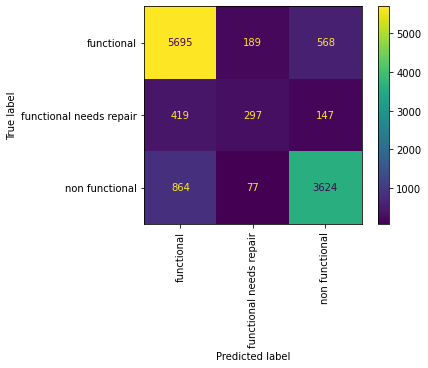

In [9]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')